In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Load data

#Begin by downloading the dataset. This tutorial uses a filtered version of Dogs vs Cats dataset from Kaggle.
#Download the archive version of the dataset and store it in the "/tmp/" directory.

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68608000/68606236 [==============================] - 36s 1us/step


In [5]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


In [8]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [9]:
#Data preparation

#Format the images into appropriately pre-processed floating point tensors before feeding to the network:

#    Read images from the disk.
#    Decode contents of these images and convert it into proper grid format as per their RGB content.
#    Convert them into floating point tensors.
#    Rescale the tensors from values between 0 and 255 to values between 0 and 1,
#    as neural networks prefer to deal with small input values.

#Fortunately, all these tasks can be done with the ImageDataGenerator class provided by tf.keras.
#It can read images from disk and preprocess them into proper tensors.
#It will also set up generators that convert these images into batches of tensors—helpful when training the network.

train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [10]:
#After defining the generators for training and validation images,
#the flow_from_directory method load images from the disk, applies rescaling,
#and resizes the images into the required dimensions.

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')


Found 2000 images belonging to 2 classes.


In [11]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')


Found 1000 images belonging to 2 classes.


In [12]:
#Visualize training images
#Visualize the training images by extracting a batch of images from 
#the training generator—which is 32 images in this example—then plot five of them with matplotlib.

sample_training_images, _ = next(train_data_gen)


In [13]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


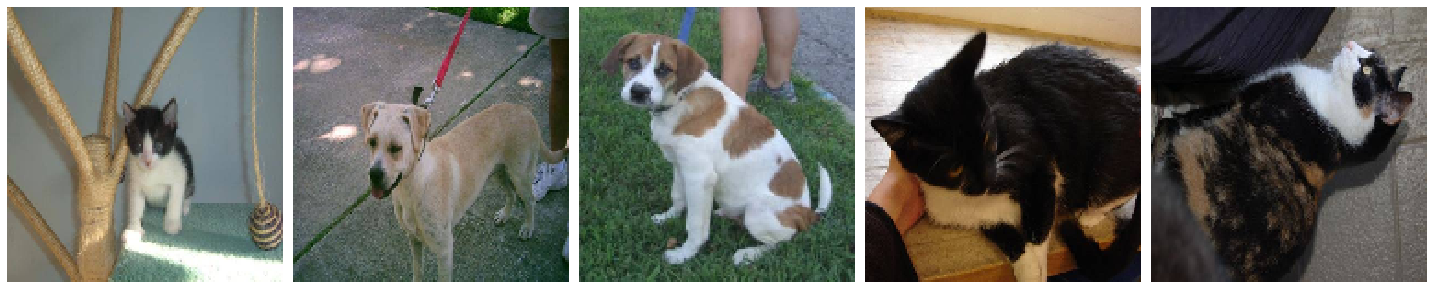

In [14]:
plotImages(sample_training_images[:5])

In [15]:
#Create the model

#The model consists of three convolution blocks with a max pool layer in each of them.
#There's a fully connected layer with 512 units on top of it that is activated by a relu activation function.
#The model outputs class probabilities based on binary classification by the sigmoid activation function.

model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [16]:
#Compile the model

#For this tutorial, choose the ADAM optimizer and binary cross entropy loss function.
#To view training and validation accuracy for each training epoch, pass the metrics argument.

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20736)             0

In [18]:
#Train the model
#Use the fit_generator method of the ImageDataGenerator class to train the network

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/15
15/15 [==============================] - 13s 841ms/step - loss: 0.7968 - accuracy: 0.4925 - val_loss: 0.6921 - val_accuracy: 0.4978
Epoch 2/15
15/15 [==============================] - 3s 221ms/step - loss: 0.6882 - accuracy: 0.5755 - val_loss: 0.6854 - val_accuracy: 0.5714
Epoch 3/15
15/15 [==============================] - 3s 216ms/step - loss: 0.6587 - accuracy: 0.6234 - val_loss: 0.6519 - val_accuracy: 0.5804
Epoch 4/15
15/15 [==============================] - 3s 220ms/step - loss: 0.6044 - accuracy: 0.6709 - val_loss: 0.5958 - val_accuracy: 0.6629
Epoch 5/15
15/15 [==============================] - 3s 217ms/step - loss: 0.5449 - accuracy: 0.7203 - val_loss: 0.5801 - val_accuracy: 0.7009
Epoch 6/15
15/15 [==============================] - 3s 220ms/step - loss: 0.4976 - accuracy: 0.7560 - val_loss: 0.5794 - val_accuracy: 0.7020
Epoch 7/15
15/15 [==============================] - 3s 227ms/step - loss: 0.4572 - accuracy: 0.7828 - val_loss: 0.5993 - val_accuracy: 0.7087
Epoch

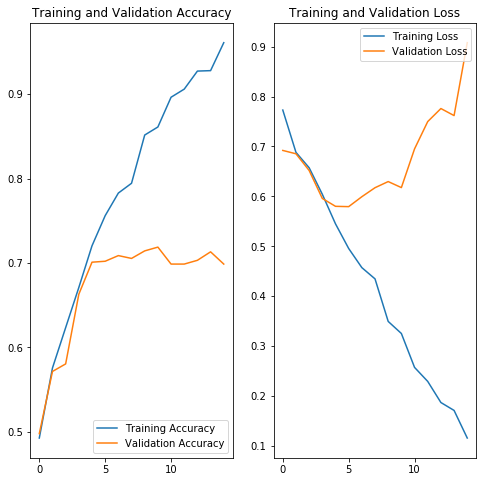

In [19]:
#Visualize training results
#Now visualize the results after training the network.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()